# INTRODUCTION TO DATA VISUALIZATION WITH PYTHON SEABORN

In [47]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification

from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neural_network import MLPClassifier as MLPC

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

from toolbox.tools import *

In [49]:
df_gm = pd.read_csv('data\\dataframe.csv')
df_ml = pd.read_csv('data\\dataframe_ml.csv')
df_ts = generate_time_series(len_series=100, n_conditions=2, n_individuals=100)
df_ln = generate_linear(n_individuals=30, n_conditions=2)
df_pl = generate_poly(n_individuals=30, n_conditions=2, order=2)

BRIEF INTRODUCTION PANDAS DATAFRAMES, MATPLOTLIB AND SEABORN

EXPLORATORY DATA VISUALIZATION

* distplot and count plot
* ridge plot
* Joint kernel density estimate

EXERCISE 1

* revelation of the data source
* discover the characteristics of the dataframe you are working on
* discover anomalies in the data

## DATA VISUALIZATION FOR HYPOTHESIS TESTING

### Visualize time series data across consitions

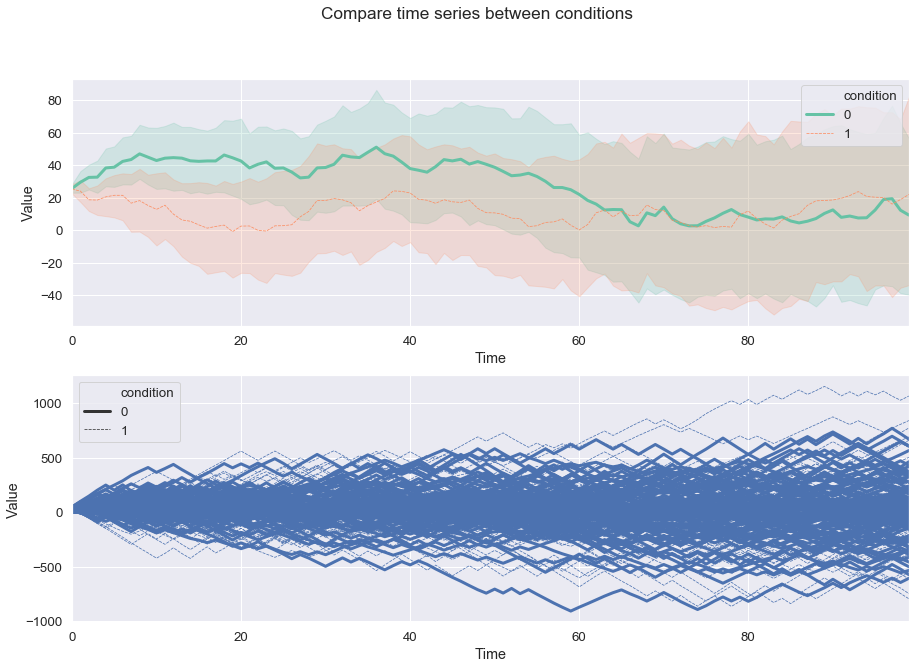

In [50]:
sns.set(font_scale=1.2)
fig,axs = plt.subplots(2, 1, figsize = (15, 10))
sns.lineplot(x='time'
             , y='value'
             , hue='condition'
             , size='condition'
             , style='condition'
             , data=df_ts
             , palette='Set2'
             , ax = axs[0]
            )
sns.lineplot(x='time'
             , y='value'
             , size='condition'
             , style='condition'
             , data=df_ts
             , palette='Set2'
             , units='individual'
             , estimator=None
             , ax = axs[1]
            )
plt.suptitle('Compare time series between conditions')
for ax in axs:
    
    ax.set_xlim(min(df_ts['time']), max(df_ts['time']))
    ax.set_xlim(min(df_ts['time']), max(df_ts['time']))
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')

plt.show()

### Visualize the reletionship between variables

In [51]:
df_sy = generate_synthetic(n_categorical=3, n_scalar=3, n_rows=1000)

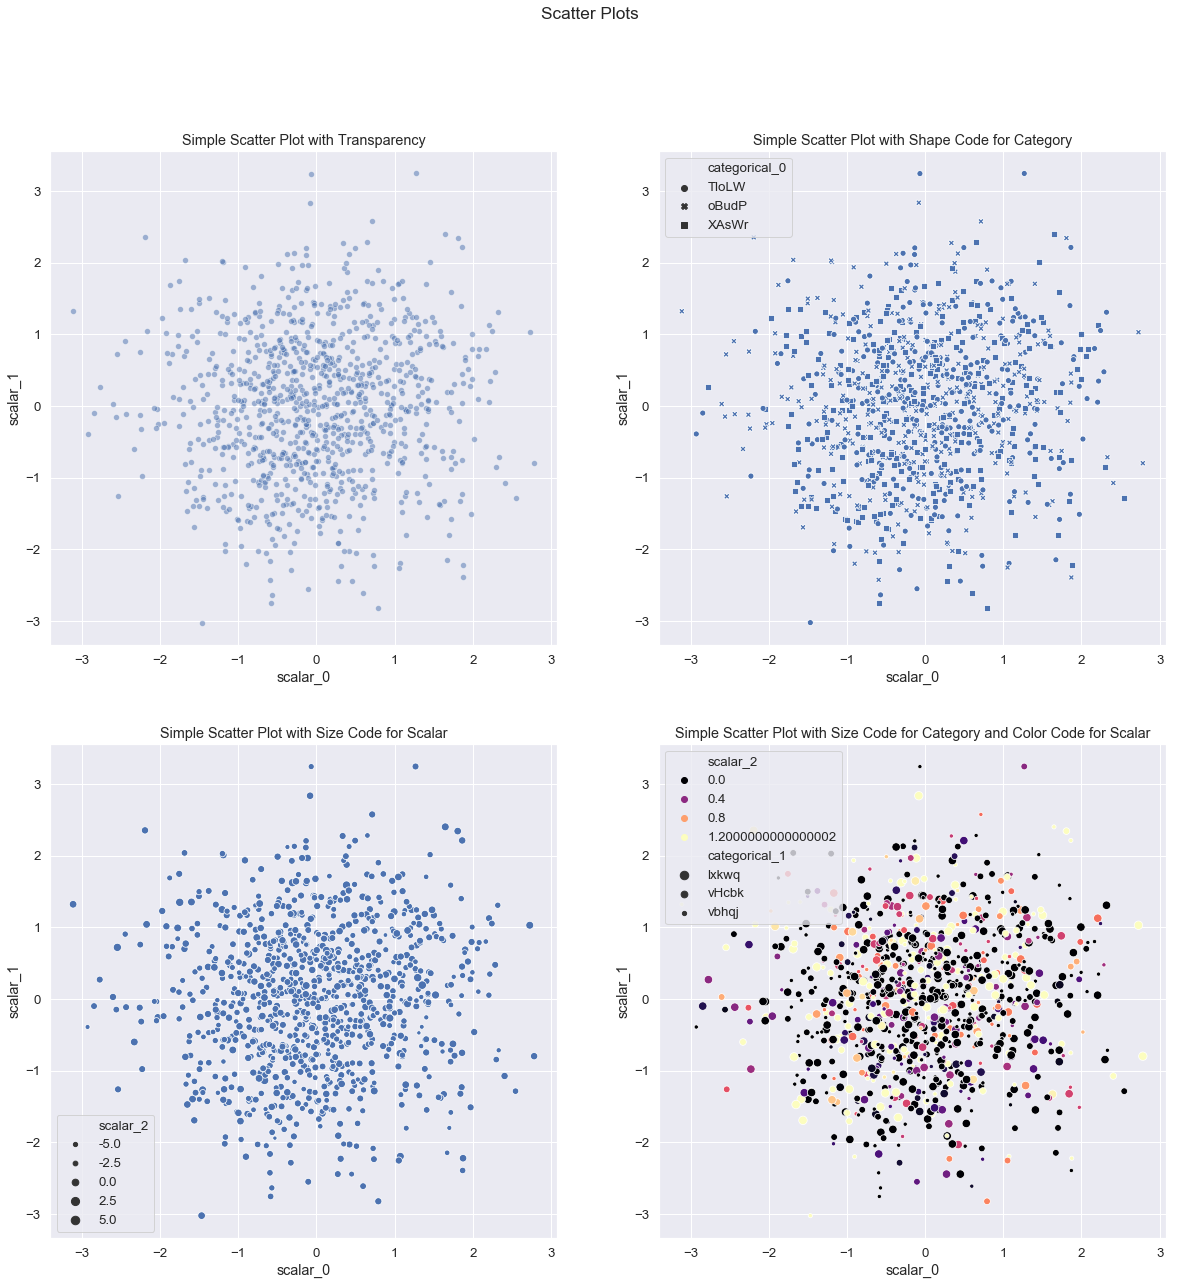

In [52]:
sns.set(font_scale=1.2)
fig, axs = plt.subplots(2, 2, figsize=(20,20))
sns.scatterplot(x='scalar_0'
                , y='scalar_1'
                , data=df_sy
                , ax = axs[0][0]
                , alpha=0.5
               )
sns.scatterplot(x='scalar_0'
                , y='scalar_1'
                , data=df_sy
                , style='categorical_0'
                , ax = axs[0][1]
               )
sns.scatterplot(x='scalar_0'
                , y='scalar_1'
                , data=df_sy
                , size='scalar_2'
                , ax = axs[1][0]
               )
sns.scatterplot(x='scalar_0'
                , y='scalar_1'
                , data=df_sy
                , size='categorical_1'
                , hue='scalar_2'
                , hue_norm=(0,1)
                , palette='magma'
                , ax = axs[1][1]
               )
axs[0][0].set_title('Simple Scatter Plot with Transparency')
axs[0][1].set_title('Simple Scatter Plot with Shape Code for Category')
axs[1][0].set_title('Simple Scatter Plot with Size Code for Scalar')
axs[1][1].set_title('Simple Scatter Plot with Size Code for Category and Color Code for Scalar')
plt.suptitle('Scatter Plots')
plt.show()

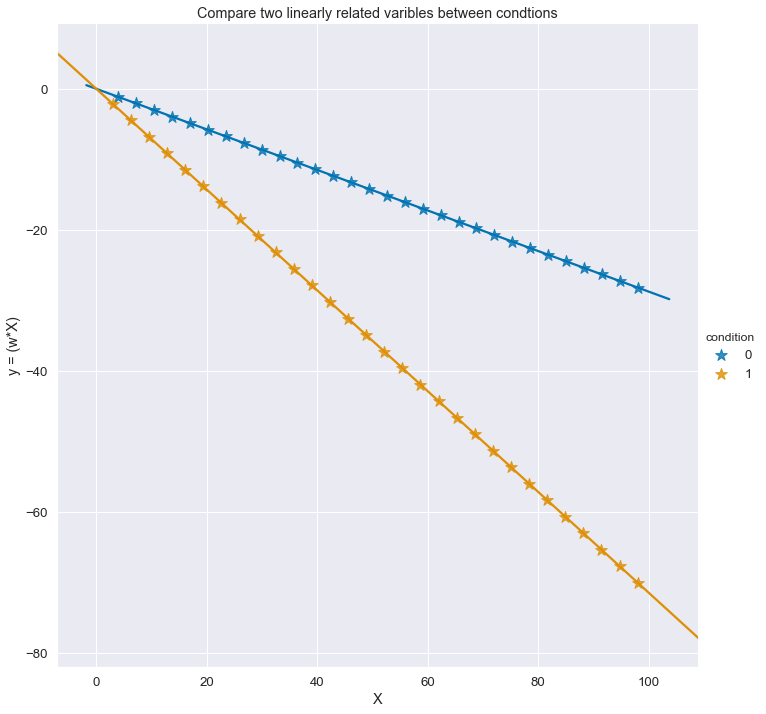

In [53]:
sns.set(font_scale=1.2, style = 'darkgrid')
sns.lmplot(x='x'
           , y='y'
           , hue='condition'
           , palette='colorblind'
           , markers='*'
           , data=df_ln
           , height=10
           , scatter_kws={'s': 150}
           )
plt.title('Compare two linearly related varibles between condtions')
plt.xlabel('X')
plt.ylabel('y = (w*X)')
plt.show()

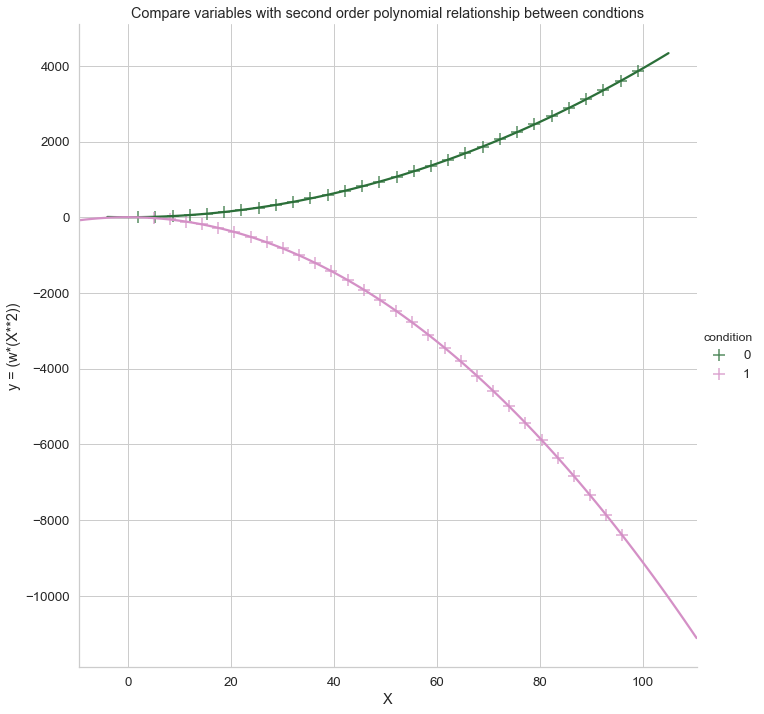

In [54]:
sns.set(font_scale=1.2, style ='whitegrid')
sns.lmplot(x='x'
           , y='y'
           , hue='condition'
           , palette='cubehelix'
           , markers='+'
           , order=2
           , data=df_pl
           , height=10
           , scatter_kws={'s': 150}
           )
plt.title('Compare variables with second order polynomial relationship between condtions')
plt.xlabel('X')
plt.ylabel('y = (w*(X**2))')
plt.show()

In [55]:
df_sy = generate_synthetic(n_categorical=0, n_scalar=10, n_rows=10000)
df_corr = df_sy.corr()
mask = df_corr < 0

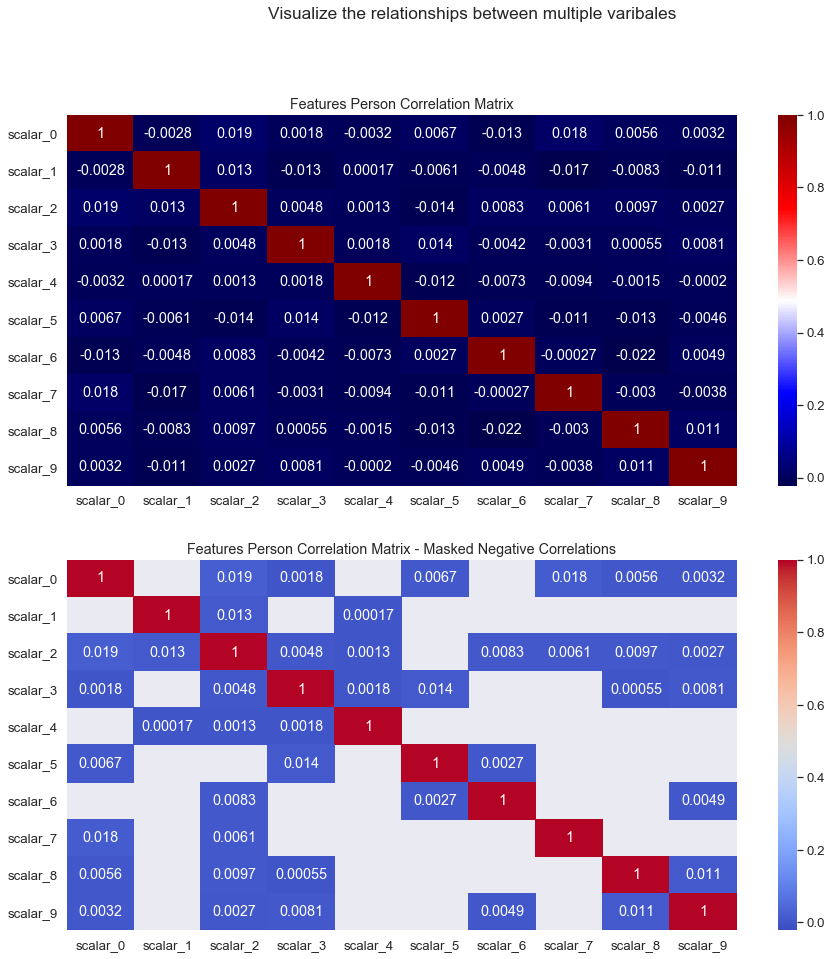

In [56]:
sns.set(font_scale=1.2)
fig, axs = plt.subplots(2,1,figsize=(15,15))
sns.heatmap(data=df_corr
            , cmap='seismic'
            , annot=True
            , ax = axs[0]
            )
sns.heatmap(data=df_corr
            , cmap='coolwarm'
            , annot=True
            , mask=mask
            , ax = axs[1]
            )
axs[0].set_title('Features Person Correlation Matrix')
axs[1].set_title('Features Person Correlation Matrix - Masked Negative Correlations')
plt.suptitle('Visualize the relationships between multiple varibales')
plt.show()

### Compare between multiple conditions

In [57]:
df_sy = generate_synthetic(n_categorical=2, n_scalar=1, n_rows=1000)

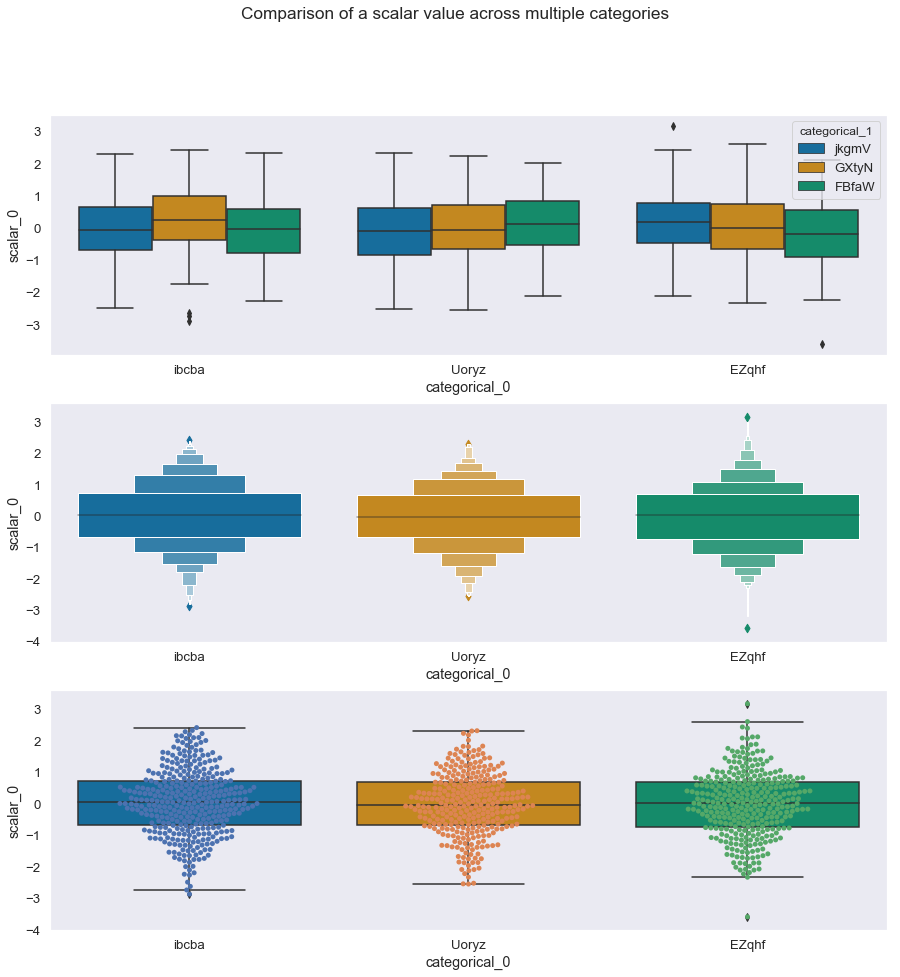

In [58]:
sns.set(font_scale=1.2, style='dark')
fig, axs = plt.subplots(3,1,figsize=(15,15))
sns.boxplot(x='categorical_0'
            , y='scalar_0' 
            , palette='colorblind'
            , hue='categorical_1'
            , ax=axs[0]
            , data=df_sy
            )
sns.boxenplot(x='categorical_0'
              , y='scalar_0' 
              , palette='colorblind'
              , ax=axs[1]
              , data=df_sy
              )
sns.boxplot(x='categorical_0'
            , y='scalar_0' 
            , palette='colorblind'
            , ax=axs[2]
            , data=df_sy
            )
sns.swarmplot(x='categorical_0'
              , y='scalar_0' 
              , cmap='colorblind'
              , ax=axs[2]
              , data=df_sy
              )

plt.suptitle('Comparison of a scalar value across multiple categories')
plt.show()

### EXERCISE 2

Using the `df_gm` formulate your own hypothesis and test it visually

* Given the data you have access to, think to a question you want, and you can, answer to
* Think at which kind of information you need to extract from the data for answering your question
* Think which visualization would best suit your purposes
* Think at which audience you want to present your visualization
* Think if you have any kind of constrains (i.e. temporal, skill ecc..) and how you can minimize their impact

It follows some informations regarding the `df_gm`

In [59]:
df_gm.head(2)

,rank,dead,online,name,level,class,id,experience,account,challenges,twitch,ladder
0,1,False,False,Tzn_NecroIsFineNow,100,Necromancer,3dcddd59f5088893f734f39686350990dae168cc4f4b00...,4250334444,TheTzn,40,thetzn,Harbinger
1,1,False,False,RaizNeverFirstQT,100,Necromancer,8f3216db5ac9106c287a834731aafc83c387138f28fc45...,4250334444,RaizQT,22,raizqt,SSF Harbinger HC


## DATA VISUALIZATION FOR MODEL EVALUATION

In [60]:
classifiers = {'K-nearest Neighbors' : KNN(n_jobs = -1)
               , 'Logistic Regression' : LR(max_iter = 200, class_weight = 'balanced', solver='sag', n_jobs = -1)
               , 'Random Forest' : RF(class_weight = 'balanced', n_jobs = -1)
               , 'Multilayer Perceptron' :  MLPC(max_iter = 200)
              }
X, y = make_classification(n_samples = 5000, n_features=15, n_informative=5, n_redundant=5)
X_validation, y_validation, X_test, y_test = generating_validation_test(X, y)

### Compare the performance of different models

In [61]:
splitter = StratifiedShuffleSplit(n_splits=10)

In [62]:
scores = []
names = []
for name, classifier in classifiers.items():
    
    for train_index, test_index in splitter.split(X, y):
        
        classifier.fit(X[train_index], y[train_index])
        scores.append(classifier.score(X[test_index], y[test_index]))
        names.append(name)

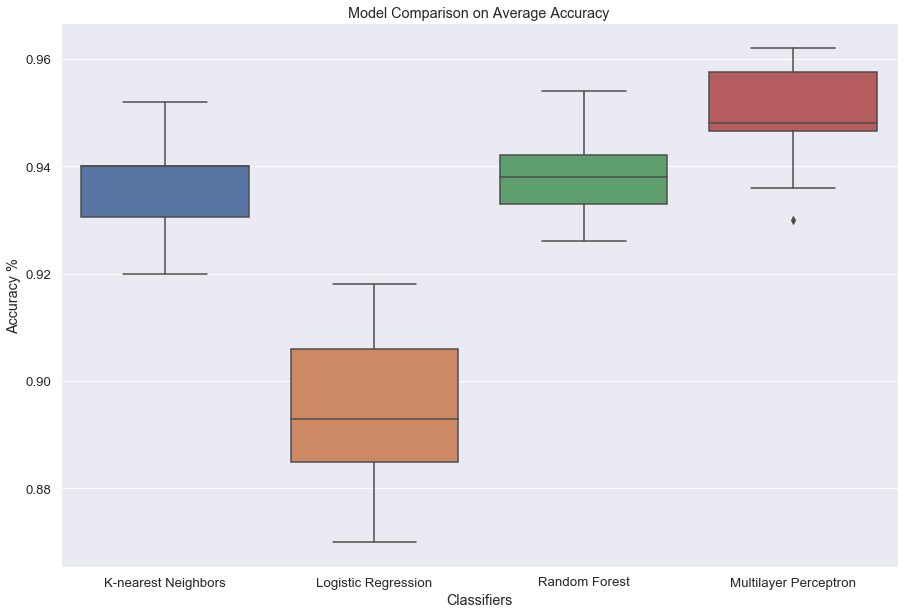

In [63]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize = (15, 10))
sns.boxplot(x = names
            , y = scores
            , orient = 'v'
            , ax = ax)
plt.title('Model Comparison on Average Accuracy')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy %')
plt.show()

### Evaluate a model more in detail

In [64]:
splitter = StratifiedShuffleSplit(n_splits=5)
param_grid = {'hidden_layer_sizes' : [(10, 10, 10), (50, 50, 50), (100, 100, 100)]
              , 'activation' : ['tanh', 'relu']
              , 'alpha' : [1.0, 0.1, 0.001, 0.0001]
             }


In [65]:
searcher = GridSearchCV(estimator=classifiers['Multilayer Perceptron']
                        , param_grid=param_grid
                        , cv=splitter
                        , scoring = 'roc_auc'
                        , n_jobs = 2
                       )
searcher.fit(X_validation, y_validation)
best_estimator = searcher.best_estimator_
y_predicted = best_estimator.predict(X_test)
cm = confusion_matrix(y_test, y_predicted)

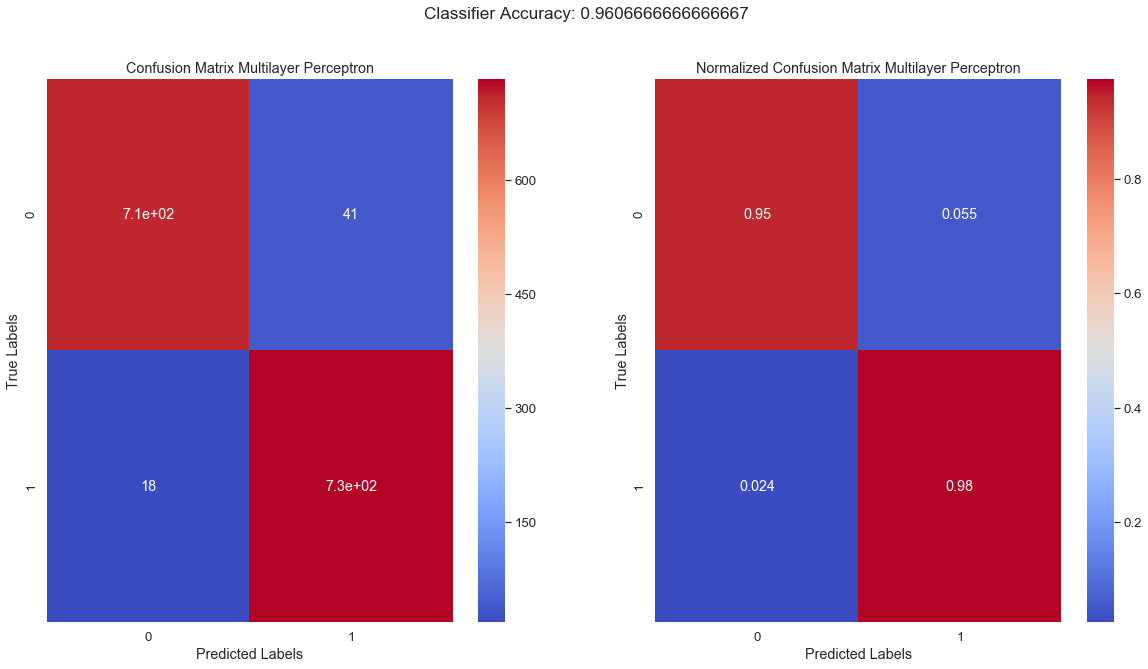

In [66]:
sns.set(font_scale=1.2)
fig, axs = plt.subplots(1, 2, figsize = (20, 10))
sns.heatmap(cm
            , annot = True
            , cmap='coolwarm'
            , ax=axs[0]
           )
sns.heatmap(cm / cm.sum(axis=1)[:, np.newaxis]
            , annot = True
            , cmap='coolwarm'
            , ax=axs[1]
           )
for ax in axs:
    
    ax.set_xticks([0.5, 1.5], ['Positive', 'Negative'])
    ax.set_yticks([0.5, 1.5], ['Negative', 'Positive'])
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

axs[0].set_title('Confusion Matrix Multilayer Perceptron')
axs[1].set_title('Normalized Confusion Matrix Multilayer Perceptron')
plt.suptitle('Classifier Accuracy: {}'.format(best_estimator.score(X_test, y_test)))
plt.show()

### Visualize the learning process 

In [67]:
best_estimator

MLPClassifier(activation='relu', alpha=1.0, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [68]:
loss_v = []
accuracy_v = []
accuracy_ts = []
epochs = [i for i in range(500)]
model = MLPC(activation='tanh', alpha=0.001, hidden_layer_sizes=(100, 100, 100), max_iter=1, warm_start=True)

In [69]:
for epoch in epochs:
    
    model.fit(X_validation, y_validation)
    loss_v.append(model.loss_)
    accuracy_v.append(model.score(X_validation, y_validation))
    accuracy_ts.append(model.score(X_test, y_test))

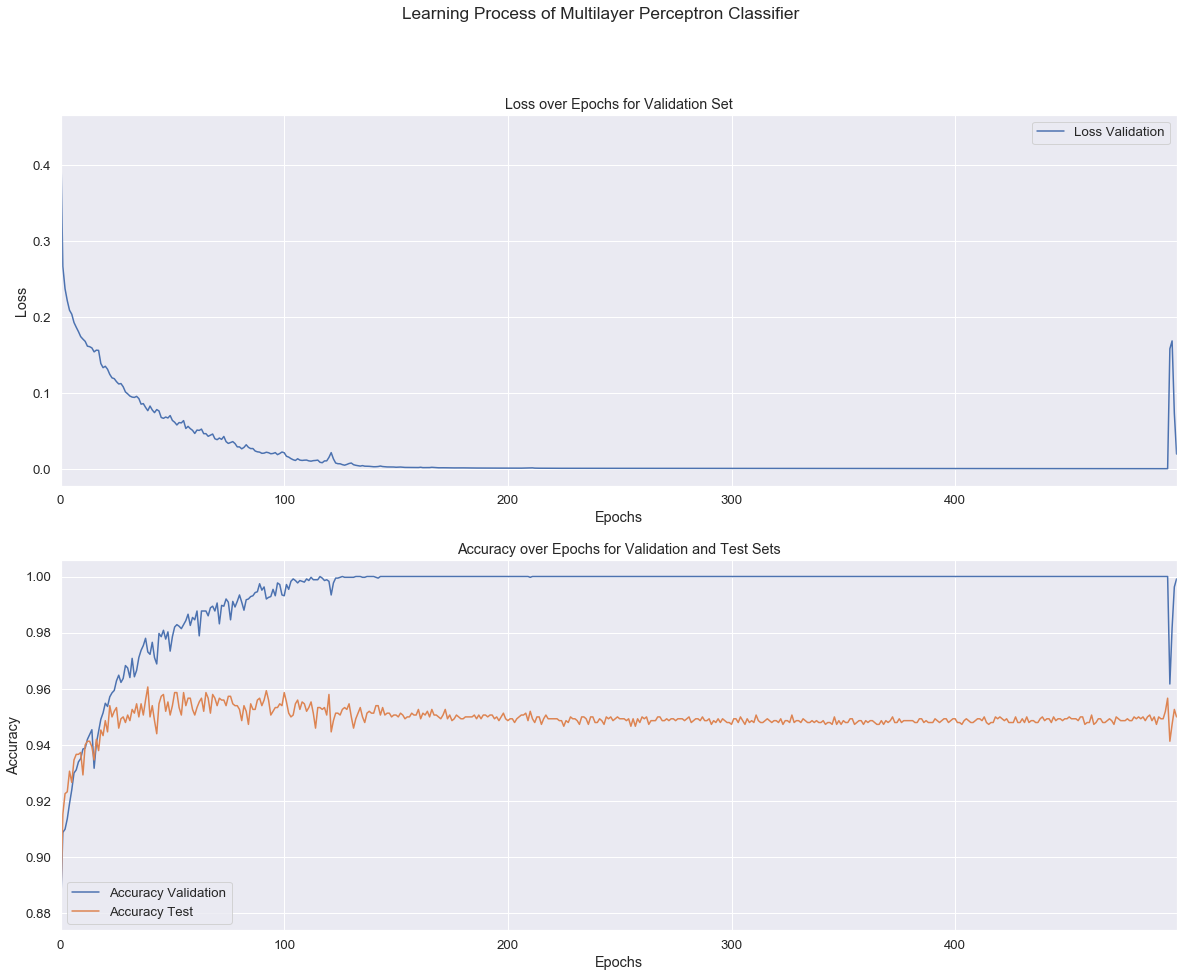

In [70]:
sns.set(font_scale=1.2)
fig, axs = plt.subplots(2, 1, figsize = (20, 15))
sns.lineplot(y=loss_v
             , x=epochs
             , label='Loss Validation'
             , ax=axs[0]
            )
sns.lineplot(y=accuracy_v
             , x=epochs
             , label='Accuracy Validation'
             , ax=axs[1]
            )
sns.lineplot(y=accuracy_ts
             , x=epochs
             , label = 'Accuracy Test' 
             , ax=axs[1]
            )

for ax in axs:
    
    ax.set_xlabel('Epochs')

    ax.set_xlim(min(epochs), max(epochs))

axs[0].set_title('Loss over Epochs for Validation Set')
axs[0].set_ylabel('Loss')
axs[1].set_title('Accuracy over Epochs for Validation and Test Sets')
axs[1].set_ylabel('Accuracy')
plt.suptitle('Learning Process of Multilayer Perceptron Classifier')
plt.legend()
plt.show()

In [71]:
n_clusters = [i for i in range(2, 15)]
inertias = []
for n in n_clusters:
    
    clusterer = KMeans(n_clusters = n).fit(X)
    inertias.append(clusterer.inertia_)

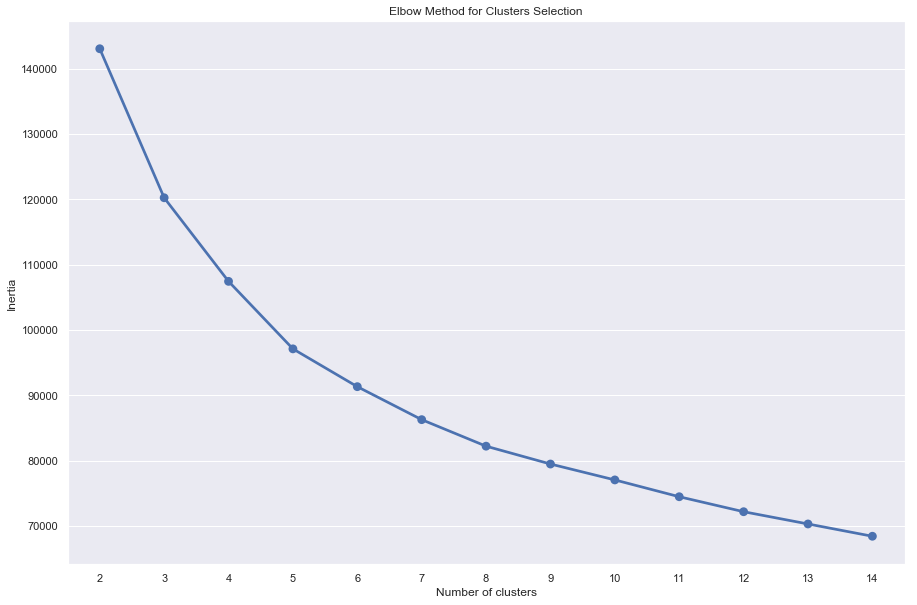

In [81]:
sns.set()
fig, ax = plt.subplots(figsize=(15, 10))
sns.pointplot(y=inertias
             , x=n_clusters
             , ax=ax
            )

ax.set_xlabel('Number of clusters')
#ax.set_xlim(min(n_clusters), max(n_clusters))
ax.set_ylabel('Inertia')
plt.title('Elbow Method for Clusters Selection')
plt.show()

### Inspect the prediction

In [73]:
y_predicted = classifiers['Logistic Regression'].fit(X_validation, y_validation).predict(X_test)
major_components = PCA(n_components = 2).fit_transform(X_test)

colors_gt = ['b' if label == 0 else 'y' for label in y_test]

colors_er = ['r' if prediction != ground_truth else 'w' for prediction, ground_truth in zip(y_predicted, y_test)]
colors_er_0 = ['r' if prediction != ground_truth and prediction == 0 else 'w' for prediction, ground_truth in zip(y_predicted, y_test)]
colors_er_1 = ['r' if prediction != ground_truth and prediction == 1 else 'w' for prediction, ground_truth in zip(y_predicted, y_test)]

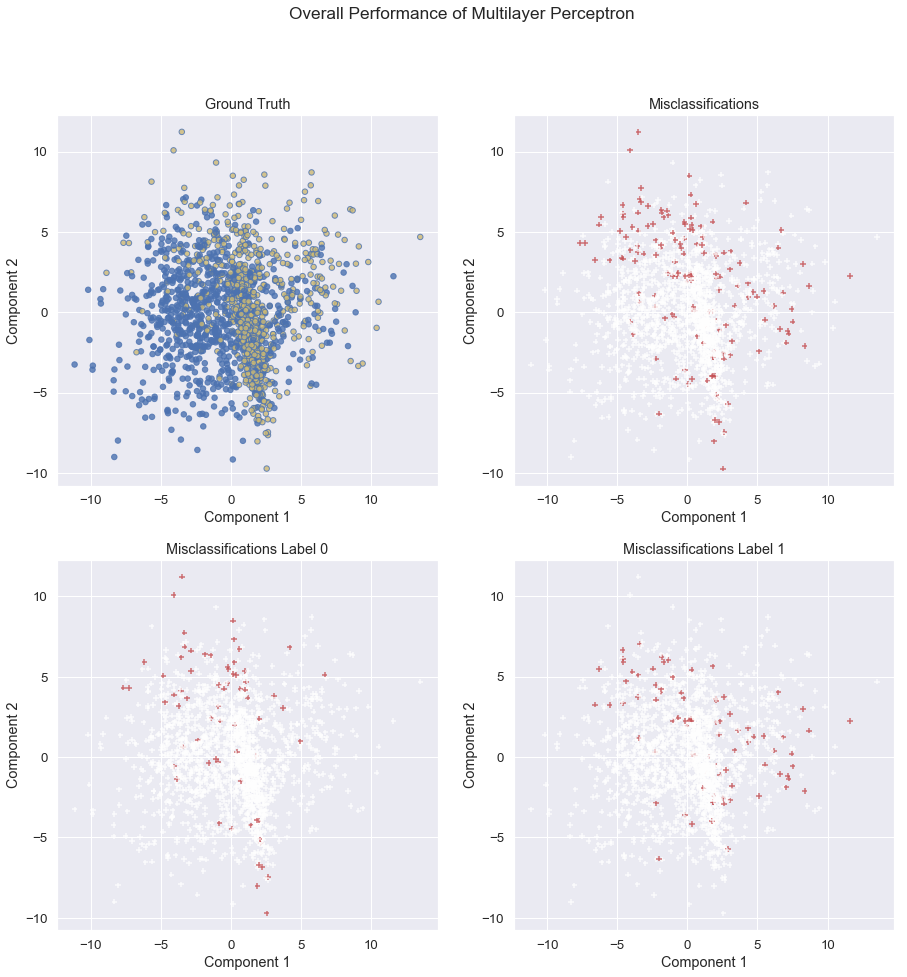

In [74]:
sns.set(font_scale=1.2)
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.regplot(major_components[:,0]
            , major_components[:,1]
            , fit_reg=False
            , scatter_kws={'facecolors':colors_gt, 's':30}
            , ax=axs[0][0]
           )
sns.regplot(major_components[:,0]
            , major_components[:,1]
            , fit_reg=False
            , scatter_kws={'facecolors':colors_er, 's':30}
            , ax=axs[0][1]
            , marker='+'
           )
sns.regplot(major_components[:,0]
            , major_components[:,1]
            , fit_reg=False
            , scatter_kws={'facecolors':colors_er_0, 's':30}
            , ax=axs[1][0]
            , marker='+'
           )
sns.regplot(major_components[:,0]
            , major_components[:,1]
            , fit_reg=False
            , scatter_kws={'facecolors':colors_er_1, 's':30}
            , ax=axs[1][1]
            , marker='+'
           )
for ax in axs.flatten():
    
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

axs[0][0].set_title('Ground Truth')
axs[0][1].set_title('Misclassifications')
axs[1][0].set_title('Misclassifications Label 0')
axs[1][1].set_title('Misclassifications Label 1')

plt.suptitle('Overall Performance of Multilayer Perceptron')
plt.show()

In [75]:
locations_er_0 = []
locations_er_1 = []
for location, prediction, ground_truth in zip(major_components, y_predicted, y_test):
    
    if prediction != ground_truth and prediction == 0:
        locations_er_0.append(location)
    elif prediction != ground_truth and prediction == 1:
        locations_er_1.append(location)

locations_er_0 = np.array(locations_er_0)
locations_er_1 = np.array(locations_er_1)

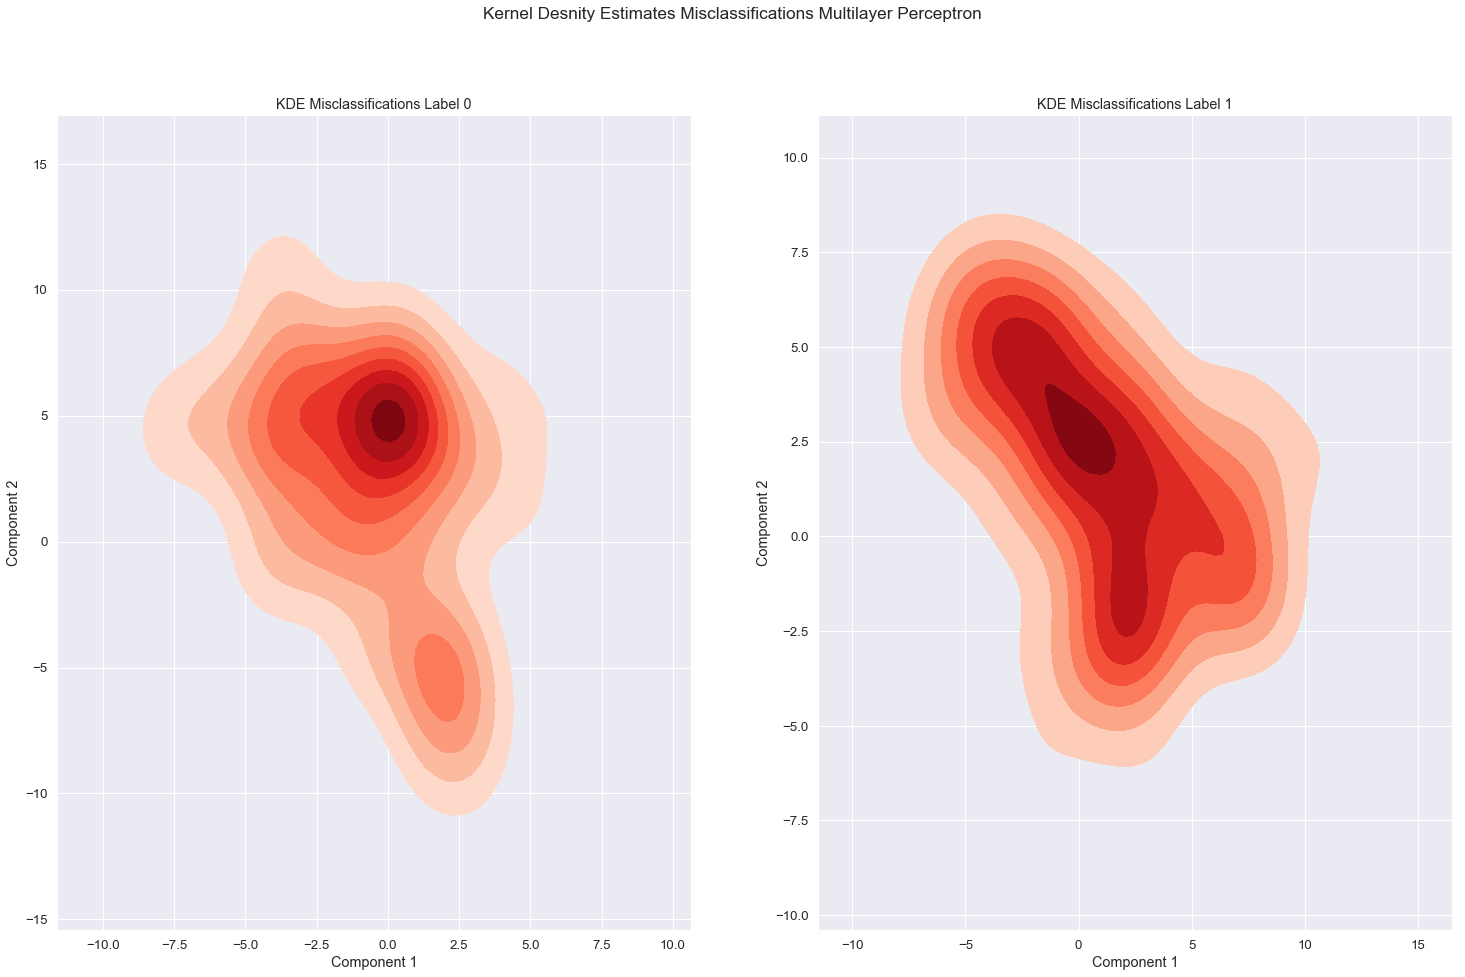

In [76]:
sns.set(font_scale=1.2)
fig, axs = plt.subplots(1, 2, figsize=(25, 15))
sns.kdeplot(locations_er_0[:,0]
        , locations_er_0[:,1]
        , cmap='Reds'
        , shade=True
        , shade_lowest=False
        , ax=axs[0]
        )
sns.kdeplot(locations_er_1[:,0]
        , locations_er_1[:,1]
        , cmap='Reds'
        , shade=True
        , shade_lowest=False
        , ax=axs[1]
        )

for ax in axs.flatten():
    
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

axs[0].set_title('KDE Misclassifications Label 0')
axs[1].set_title('KDE Misclassifications Label 1')
plt.suptitle('Kernel Desnity Estimates Misclassifications Multilayer Perceptron')
plt.show()

In [77]:
components_corr = np.append(X_test, major_components, axis = 1)
components_corr = pd.DataFrame(components_corr).corr()
components_corr = components_corr[[15, 16]]

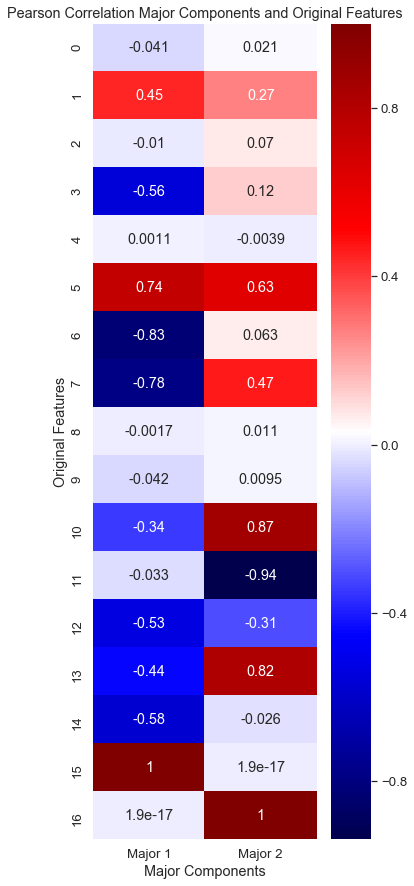

In [78]:
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(5, 15))
sns.heatmap(components_corr
            , annot = True
            , cmap='seismic'
            , ax = ax
           )
plt.title('Pearson Correlation Major Components and Original Features')
ax.set_xticklabels(labels=['Major 1', 'Major 2'])
ax.set_xlabel('Major Components')
ax.set_ylabel('Original Features')
plt.show()

### EXERCISE 2

You can find in the following cell arrays of preprocessed data for training your model in the attempt to predict if a player died or not.

In case you prefer doing your own preprocessing (suggested) you can use the `df_ml`, which has been already prepared for being in a machine learning friendly format.

The goal here is to pick a strategy for solving the classification problem and using a visual for validating the outcomes of your strategy.

In [79]:
X, y = generate_X_y(df_ml, list(df_ml.drop('dead', 1)), 'dead')
X_validation, y_validation, X_test, y_test = generating_validation_test(X, y)